### Open PACE data

In [1]:
import earthaccess
import cartopy.crs as ccrs
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xarray as xr
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


In [2]:
def quickLook(dataset):
    print('Running [quickLook]: cropping dataset...')
    point=[-76.34890, 39.12351] #red_665 = 141
    plot_data = dataset["Rrs"][:, :, 141].where(
        ((dataset["latitude"] > 36.9)
            & (dataset["latitude"] < 39.7)
            & (dataset["longitude"] > -76.8)
            & (dataset["longitude"] < -75.6)
        ),drop=True,)
    print(f'quicklook: {date}')
    #--- plot
    latitude = plot_data.coords['latitude'].values
    longitude = plot_data.coords['longitude'].values
    fig = plt.figure(figsize=(5,3))
    ax = plt.axes(projection=ccrs.PlateCarree())
    shapefile_path = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_250m/Composite/Chesapeake_Bay_Shoreline_High_Resolution.shp'
    gdf = gpd.read_file(shapefile_path)
    gdf.boundary.plot(ax=ax, facecolor='white', edgecolor='black', alpha=1, linewidth=0.7 , zorder = 1)
    # Plot data
    im = ax.pcolormesh(longitude, latitude, plot_data, cmap='viridis', transform=ccrs.PlateCarree())    
    plt.show()

In [3]:
EARTHDATA_USERNAME = 'slsmit34'
EARTHDATA_PASSWORD = 'ZzhGj201312!?sls' #ZzhGj201312!?sls
auth = earthaccess.login(strategy="interactive", persist=True)

### 1. Load and geolocate PACE_OCI_L2_AOP_NRT

In [4]:
tspan = ("2024-04-26", "2024-04-27")
bbox = (-76.75, 36.97, -75.74, 39.01)
clouds = (0, 100)
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    version = '3.0',
    temporal=tspan,
    point=(-76.34890, 39.12351),
    #bounding_box = bbox,
    #cloud_cover = clouds,
)
import pandas as pd
results_df = pd.json_normalize(results)
print(results_df['meta.native-id'])
results_df

Granules found: 1
0    PACE_OCI_L2_AOP_PACE_OCI.20240426T172015.L2.OC...
Name: meta.native-id, dtype: object


,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.EndingDateTime,...,umm.RelatedUrls,umm.CloudCover,umm.DataGranule.ProductionDateTime,umm.DataGranule.Identifiers,umm.DataGranule.ArchiveAndDistributionInformation,umm.DataGranule.DayNightFlag,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version
0,159.704784,granule,G3401848547-OB_CLOUD,1,PACE_OCI_L2_AOP_PACE_OCI.20240426T172015.L2.OC...,C3385049983-OB_CLOUD,OB_CLOUD,application/vnd.nasa.cmr.umm+json,2025-02-10T23:15:26.323Z,2024-04-26T17:25:15Z,...,"[{'MimeType': 'image/png', 'Format': 'PNG', 'T...",44.3,2025-02-10T18:34:44.626Z,"[{'IdentifierType': 'ProducerGranuleId', 'Iden...",[{'Name': 'PACE_OCI.20240426T172015.L2.OC_AOP....,Day,"[{'ShortName': 'PACE', 'Instruments': [{'Short...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6


Download the files

In [5]:
#Download files
paths = earthaccess.open(results)

 Opening 1 granules, approx size: 0.16 GB


QUEUEING TASKS | : 1it [00:00, 1771.99it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 22795.13it/s]


Use quicklook method to see if it is a good scene

*** Working with path [0]: <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240426T172015.L2.OC_AOP.V3_0.nc>

Dataset has been loaded in.
    File date: 2024-04-26
Running [quickLook]: cropping dataset...
quicklook: 2024-04-26


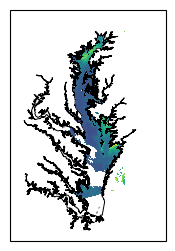

In [6]:
#Work with a file
i = 0
print(f'*** Working with path [{i}]: {paths[i]}')
dataset = xr.open_dataset(paths[i], group="geophysical_data")
rrs = dataset["Rrs"]
dataset = xr.open_dataset(paths[i], group="navigation_data")
dataset = dataset.set_coords(("longitude", "latitude"))
dataset = xr.merge((rrs, dataset))
date = str(paths[i])[109:113] + '-' + str(paths[i])[113:115] + '-' + str(paths[i])[115:117] 
dateID = str(paths[i])[109:-1]
print(f'\nDataset has been loaded in.\n    File date: {date}')
quickLook(dataset)

Crop file to CB (target area)

In [7]:
#Crop file
print('cropping to CB...')
point=[-76.34890, 39.12351]
rrs_box = dataset["Rrs"].where(
    ((dataset["latitude"] > 36.9)
        & (dataset["latitude"] < 39.7)
        & (dataset["longitude"] > -76.8)
        & (dataset["longitude"] < -75.6)
    ),drop=True,)
print(rrs_box.sizes)
#Existing wavelength bands
red_665 = 141
green_560 = 89 #3
blue_490 = 61
Ublue_443 = 42
rrs_700 = 170
VNIR_842 = 0 #b8, not in range
shapefile_path = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_250m/Composite/Chesapeake_Bay_Shoreline_High_Resolution.shp'
rrs_green = rrs_box[:, :, green_560]
rrs_red = rrs_box[:, :, red_665]
NDTI = (rrs_red - rrs_green)/(rrs_red + rrs_green)
print('Done!')

cropping to CB...
Frozen({'number_of_lines': 232, 'pixels_per_line': 121, 'wavelength_3d': 172})
Done!


Plot the cropped scene

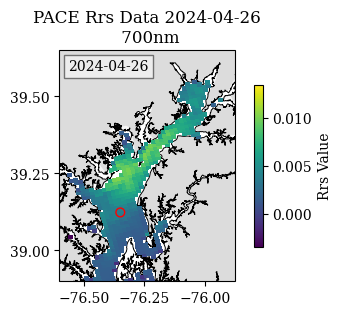

In [8]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

#Plot the cropped scene
band = red_665
import geopandas as gpd
rrs_data = rrs_box[:, :, band]
latitude = rrs_data.coords['latitude'].values
longitude = rrs_data.coords['longitude'].values

#figure
fig = plt.figure(figsize=(5,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('whitesmoke')
gdf = gpd.read_file(shapefile_path)
gdf.boundary.plot(ax=ax, facecolor='white', edgecolor='black', alpha=1, linewidth=0.7 , zorder = 1)

#add the data
im = ax.pcolormesh(longitude, latitude, rrs_data, cmap='viridis', transform=ccrs.PlateCarree())    

#formatting
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black',color = 'gainsboro')
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Rrs Value')

#title and labels
date = str(paths[i])[109:113] + '-' + str(paths[i])[113:115] + '-' + str(paths[i])[115:117] 
plt.title(f'PACE Rrs Data {date}\n 700nm')
aerlon= -76.34890 #aero
aerlat = 39.12351 #aero
min_lon, max_lon = -76.6, -75.875  
min_lat, max_lat = 38.9, 39.65  
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

#tick marks every 0.25 degrees
ax.set_xticks(np.arange(-76.5, -75.9, 0.25), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(39, 39.6, 0.25), crs=ccrs.PlateCarree())
ax.text(0.05, 0.96, date, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='square', facecolor='white', edgecolor='black', alpha=0.5))
plt.scatter(aerlon, aerlat, facecolor = 'none',edgecolors='red',s  = 40, label = 'AERONET-OC')

#plt.legend()
import cartopy.io.img_tiles as cimgt
plt.show()

In [9]:
#save scene for phydotax processing
rrs_box.to_netcdf(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/PACE_cropped/V3/{dateID}')

In [15]:
text = xr.open_dataset(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/PACE_cropped/V3/{dateID}')

### 3. Get Spectra at Aeronet site:

In [14]:
print('running')
import os
date = '20240426'
for file in os.listdir(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/PACE_cropped/V3/{date[0:4]}'):
    if  date in file:
        dataset = xr.open_dataset(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/PACE_cropped/V3/{date[0:4]}/{file}')
    else: print('no file found')

print('getting wvls')
try:
    df = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/PACE_cropped/wavelengths/{dateID}')
except:
    df = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/PACE_cropped/wavelengths/default.nc')
actual_wavelengths = df['wavelength']
dataset

running
no file found
no file found
getting wvls


<xarray.Dataset> Size: 20MB
Dimensions:    (number_of_lines: 232, pixels_per_line: 121, wavelength_3d: 172)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 112kB ...
    latitude   (number_of_lines, pixels_per_line) float32 112kB ...
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    Rrs        (number_of_lines, pixels_per_line, wavelength_3d) float32 19MB ...

In [38]:
# To get the actual wavelengths, run this....
bandWvls = xr.open_dataset(paths[i], group="sensor_band_parameters")
actual_wavelengths = bandWvls['wavelength_3d'].data
df = pd.DataFrame(actual_wavelengths, columns = ['wavelength'])
df.to_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/PACE_cropped/wavelengths/default.nc')

In [15]:
def calcPixelSpectra(longitude, latitude):
    print('part 1')
    flat_lon = dataset['longitude'].values.flatten()
    flat_lat = dataset['latitude'].values.flatten()
    distances = np.sqrt((flat_lon - longitude)**2 + (flat_lat - latitude)**2)
    min_index = np.argmin(distances)
    print('part 2')
    #convert the flat index back to 2D indices
    lon_idx, lat_idx = np.unravel_index(min_index, dataset['longitude'].shape)
    print(lon_idx, lat_idx)
    print('part 3')
    #crop the ds using the indices
    cropped_dataset = dataset.isel(number_of_lines=lon_idx, pixels_per_line=lat_idx)
    print(cropped_dataset['Rrs'][0].data)
    #extract the Rrs variable
    rrs_data = cropped_dataset['Rrs']
    
    #wavelengths = cropped_dataset['wavelength_3d'].data
    assert len(actual_wavelengths) == len(rrs_data), "Mismatch in the number of wavelengths and Rrs layers"
    return(rrs_data)
longitudeAE, latitudeAE = -76.34890, 39.12351 #aero
rrs_AE = calcPixelSpectra(longitudeAE, latitudeAE)

part 1
part 2
172 64
part 3
-0.0062460005


### 4. Get Aeronet Spectra

In [16]:
#Load in packages
import os
import numpy as np
import math
import pandas as pd
import scipy.io as sp
import warnings
warnings.filterwarnings("ignore")

# Load in aeronet file 
print(f'Query for [{date[0:4]}]')
for file in os.listdir(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet'):
    if date[0:4] in file:
        df_aero = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/{file}') #load in df_aero

df_aero = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/2021_V3_L15.csv')
print(f' original length: {len(df_aero)}')
years =  [2022, 2023, 2024, 2025]
for yearTemp in years:
    print(f'\nrunning {yearTemp}')
    temp = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/{yearTemp}_V3_L15.csv')
    print(f'{yearTemp} df: {len(temp)}')
    df_aero = pd.concat([df_aero, temp], axis=0)
    print(f'current df: {len(df_aero)}')
    print(f'{yearTemp} appended\n----\n')


aeroWvls = [400, 412, 443, 490, 510, 532, 560, 620, 667, 681, 709, 779, 865, 870, 1020] #These are the wavelengths of Aeronet


print(f"---- Aeronet File ----\n  (1) Processing level: [{str(df_aero['Data_Quality_Level'][0])}]\n  (2) # Samples: [{len(df_aero)}]\n  (3) Time Range (dd-mm-yyyy): [{str(df_aero['Date(dd-mm-yyyy)'][0])} -- {str(df_aero['Date(dd-mm-yyyy)'][-1:])[8:18]}]\n  (4) Wavelengths: {aeroWvls}\n---------------------- ")

Query for [2024]
 original length: 10

running 2022
2022 df: 3126
current df: 3136
2022 appended
----


running 2023
2023 df: 5297
current df: 8433
2023 appended
----


running 2024
2024 df: 5453
current df: 13886
2024 appended
----


running 2025
2025 df: 674
current df: 14560
2025 appended
----

---- Aeronet File ----
  (1) Processing level: [0    lev15
0    lev15
0    lev15
0    lev15
0    lev15
Name: Data_Quality_Level, dtype: object]
  (2) # Samples: [14560]
  (3) Time Range (dd-mm-yyyy): [0    07:10:2021
0    16:02:2022
0    01:01:2023
0    02:01:2024
0    01:01:2025
Name: Date(dd-mm-yyyy), dtype: object -- 4:03:2025
]
  (4) Wavelengths: [400, 412, 443, 490, 510, 532, 560, 620, 667, 681, 709, 779, 865, 870, 1020]
---------------------- 


In [17]:
#Debugging: 03/06/2025
bulkAeroRrsDf = pd.DataFrame(columns = ['rrs_400', 'rrs_412', 'rrs_443', 'rrs_490', 'rrs_510', 'rrs_532',
       'rrs_560', 'rrs_620', 'rrs_667', 'Lwn_IOP[681nm]', 'Lwn_IOP[709nm]',
       'rrs_779', 'date', 'time'])
for insNum in df_aero['AERONET_Instrument_Number'].unique():
    try:
        print(f' Ins Num: {insNum}')
        df_aeroCrop = df_aero[df_aero['AERONET_Instrument_Number'] == insNum]
        print(f'cropped length: {len(df_aeroCrop)}')
        dayFactor = 360 / 365.256364
        ecc = 0.01672
        insNum = str(insNum)[0:4]
    
        #Get spectrally convolved f0's from matlab file
        mat_contents = sp.loadmat('/panfs/ccds02/nobackup/people/slsmit34/Scripts/2023_2024/f0_convolved_AERONET.mat')
        bands = mat_contents['f0']['nominalBands'][0][0][0]
        f0s = mat_contents['f0'][f'i{insNum}'][0][0][0] * 100 #Multiply by scaling factor for correct units
        f0_unconvolved = pd.DataFrame(data={'f0s': f0s[:]}, index=bands[:]).T
        f0_unconvolved.head()
        #Enter the desired Lwn category. Here, I use Lwn_IOP for coastal areas (case 2 waters BDRF corrected)
        lwnType = 'Lwn_IOP'
        # Create new df with relevant info
        df_lwn = df_aeroCrop[['Day_of_Year', f'{lwnType}[400nm]', f'{lwnType}[412nm]', f'{lwnType}[443nm]', f'{lwnType}[490nm]', f'{lwnType}[510nm]',f'{lwnType}[532nm]',f'{lwnType}[560nm]', f'{lwnType}[620nm]', f'{lwnType}[667nm]'
                         , f'{lwnType}[681nm]', f'{lwnType}[709nm]', f'{lwnType}[779nm]']]
        df_aeroCrop['Date(dd-mm-yyyy)'] = pd.to_datetime(df_aeroCrop['Date(dd-mm-yyyy)'], format='%d:%m:%Y') #Include year
        df_lwn['date'] = df_aeroCrop['Date(dd-mm-yyyy)']
        df_lwn['Year'] = df_aeroCrop['Date(dd-mm-yyyy)'].dt.year
        def map_dop(year): #Get day of Perihelion (DoP)
            if year == 2021: return 2
            elif year == 2024: return 3
            elif year in [2023, 2022,2025]:return 4
        df_lwn['DoP'] = df_lwn['Year'].apply(map_dop) # Create new col for DoP
        df_lwn['dES'] = 1 - ecc * df_lwn.apply(lambda row: math.cos(dayFactor * (row['Day_of_Year'] - row['DoP'])), axis=1) # calculate dES
        df_lwn.head()
        aero_rrs = pd.DataFrame()
        cols1, cols2 = [], []
        for col in df_lwn.columns:
            for col2 in f0_unconvolved.columns:
                #print(f' col: ...{col[8:-3]}.. col2: ...{col2}')
                try:
                    cols1.append(col)
                    cols2.append(col2)
                    if (col[8:-3]) == str(col2): 
                        print(f' col: ...{col[8:-3]}.. col2: ...{col2}')
                        aero_rrs[col] = df_lwn[col].values / (f0_unconvolved[col2].values * df_lwn['dES']) #final calculation for Rrs
                except:
                    pass;
        column_mapping = {
            'Lwn_IOP[400nm]': 'rrs_400',
            'Lwn_IOP[412nm]': 'rrs_412',
            'Lwn_IOP[443nm]': 'rrs_443',
            'Lwn_IOP[490nm]': 'rrs_490',
            'Lwn_IOP[510nm]': 'rrs_510',
            'Lwn_IOP[532nm]': 'rrs_532',
            'Lwn_IOP[560nm]': 'rrs_560',
            'Lwn_IOP[620nm]': 'rrs_620',
            'Lwn_IOP[667nm]': 'rrs_667',
            'Lwn_IOP[779nm]': 'rrs_779'}
        aero_rrs = aero_rrs.rename(columns=column_mapping)
        aero_rrs['date'] = df_aeroCrop['Date(dd-mm-yyyy)']
        aero_rrs['time'] = df_aeroCrop['Time(hh:mm:ss)']
        aero_rrs['time'] = pd.to_datetime(aero_rrs['time'])
        print(len(aero_rrs))
        #Concatenate to bulk df
        bulkAeroRrsDf = pd.concat([bulkAeroRrsDf, aero_rrs])

        ZULU_time = dateID[9:15]
        hour = int(ZULU_time[:2])
        minute = int(ZULU_time[2:4])
        second = int(ZULU_time[4:6])

        start_timestr = f'{hour-6}:{minute}:{second} AM'
        end_timestr = f'{hour-16}:{minute}:{second} PM'
        print(f'{start_timestr} // {end_timestr}')

        start_time = pd.to_datetime(start_timestr).time()
        print(start_time)
        end_time = pd.to_datetime(end_timestr).time()
        print(end_time)
    
        #start_time = pd.to_datetime('8:00:00 AM').time()
        #end_time = pd.to_datetime('7:00:00 PM').time()
        
        # Filter the DataFrame based on the time range 
        #---THIS IS NOT WORKING!!!!----
        #aero_rrs = aero_rrs[(aero_rrs['time'].dt.time >= start_time) & (aero_rrs['time'].dt.time <= end_time)]
    except:
        print(f'{insNum} failed')
aero_rrs = bulkAeroRrsDf

 Ins Num: 1017.0
cropped length: 9207
 col: ...400.. col2: ...400
 col: ...412.. col2: ...412
 col: ...443.. col2: ...443
 col: ...490.. col2: ...490
 col: ...510.. col2: ...510
 col: ...532.. col2: ...532
 col: ...560.. col2: ...560
 col: ...620.. col2: ...620
 col: ...667.. col2: ...667
 col: ...681.. col2: ...681
 col: ...709.. col2: ...709
 col: ...779.. col2: ...779
9207
11:20:15 AM // 1:20:15 PM
11:20:15
13:20:15
 Ins Num: nan
cropped length: 0
nan failed
 Ins Num: 1309.0
cropped length: 5352
 col: ...400.. col2: ...400
 col: ...412.. col2: ...412
 col: ...443.. col2: ...443
 col: ...490.. col2: ...490
 col: ...510.. col2: ...510
 col: ...532.. col2: ...532
 col: ...560.. col2: ...560
 col: ...620.. col2: ...620
 col: ...667.. col2: ...667
 col: ...681.. col2: ...681
 col: ...709.. col2: ...709
 col: ...779.. col2: ...779
5352
11:20:15 AM // 1:20:15 PM
11:20:15
13:20:15


In [19]:
print(date)
aero_rrs_poi = aero_rrs[aero_rrs['date'] == date]
aero_avg = aero_rrs_poi.mean()
aero_avg

20240426


rrs_400                                0.001982
rrs_412                                0.002225
rrs_443                                0.003079
rrs_490                                0.005079
rrs_510                                 0.00628
rrs_532                                     NaN
rrs_560                                0.010509
rrs_620                                0.008352
rrs_667                                0.005531
Lwn_IOP[681nm]                              NaN
Lwn_IOP[709nm]                              NaN
rrs_779                                0.001469
date                        2024-04-26 00:00:00
time              2025-03-19 17:40:14.466666496
dtype: object

In [21]:
#SEASON DATA
#lat/lon: -76.34890, 39.12351

viirs_wavelengths = [410,443,486,551,671]
olci_wavelengths = [400,412,443,490,510,560,620,665,674,681,709]
modis_wavelengths = [412, 443, 469, 488, 531, 547, 555, 645, 667, 678]

#3-16-2024 storm
if date == '2024-03-16' or date =='20240316':
    viirs_data = [-.00103, .00094, .00311, .00831, .00637]
    modis_data = [.00048, .00188, .00279, .00378, .00786, .00942, .00994, .00879, .00639, .00589]
    olci_data = [-.00077, -.00032, .00174, .00423, .00588, .01213, .01087, .00726, .00651, .00698, .00849]

#4-7-2024 storm
if date == '2024-04-07' or date == '20240407':
    viirs_data = [-.0023, .00201, .00652, .01641, .02085] #T=183600
    #viirs_data = [.00339, .00503, .00694, .01378, .01625] #T=165440
    olci_data = [.00682, .00725, .00958, .01259, .01434, .02066, .02145, .01977, .01946, .01954, .01570]

if date == '2024-04-26' or date == '20240426':
    viirs_data = [-.00012, .00132, .00313, .00787, .00417]
    olci_data = [-.00277, -.00154, -.00004, .00195, .00311, .00781, .00562, .00360, .00327, .00358, .00372]

#7-03-2024 summer
#viirs_data = [0.00190, 0.00269, 0.00429, 0.00894, 0.00519]
#olci_data = [-0.00186, -0.00153, -0.00028, 0.00163, 0.00289, 0.00716, 0.00525, 0.00394, 0.00366, 0.00403, 0.00420]

#9-20-2024 fall
#viirs_data = [0.00190, 0.00269, 0.00429, 0.00894, 0.00519]
#olci_data = [-0.00037, 0.00070, 0.00150, 0.00225, 0.00254, 0.00474, 0.00312, 0.00213, 0.00206, 0.00222, 0.00145]

#aero_avg[0:-5].index = aero_avg[0:-5].index.astype(int)
sliced_aero_avg = aero_avg[0:-5]

# Rename the index of the sliced Series
renamed_sliced_aero_avg = sliced_aero_avg.rename(index=lambda x: x.split('_')[1])

# Print the renamed sliced Series to verify the changes
renamed_sliced_aero_avg.index = renamed_sliced_aero_avg.index.astype(int)

wavelengths = renamed_sliced_aero_avg[0:-5].index
values = renamed_sliced_aero_avg[0:-5].values
rrs_data = rrs_AE.data

print(f'viirs: {viirs_data}')
print(f'olci: {olci_data}')
#print(f'modis: {modis_data}\n{date}')

viirs: [-0.00012, 0.00132, 0.00313, 0.00787, 0.00417]
olci: [-0.00277, -0.00154, -4e-05, 0.00195, 0.00311, 0.00781, 0.00562, 0.0036, 0.00327, 0.00358, 0.00372]


In [22]:
wavelengths = [int(key.split('_')[1]) for key in aero_avg[0:-5].index]
data_values = aero_avg[0:-5].values
wavelengths_array = np.array(wavelengths)
values = np.array(data_values, dtype=float)
print("Wavelengths:", wavelengths_array)
print("Data:", values)

Wavelengths: [400 412 443 490 510 532 560 620 667]
Data: [0.00198182 0.00222518 0.00307855 0.00507941 0.00628029        nan
 0.01050946 0.00835238 0.0055311 ]


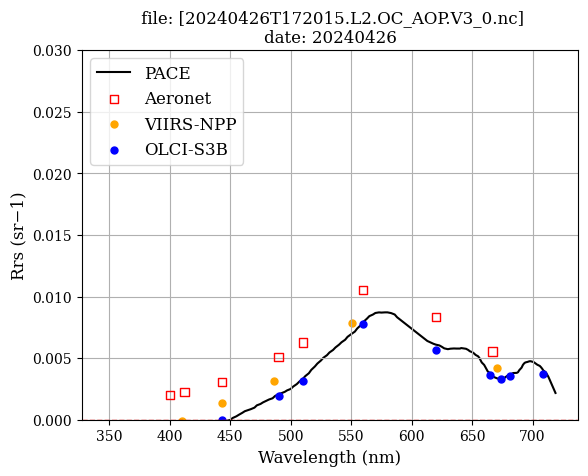

In [23]:
#Plot TSM
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib_scalebar.scalebar import ScaleBar

rcParams['font.family'] = 'serif'

# Create the scatter plot
fig,ax = plt.subplots()
#ax.set_facecolor('whitesmoke')
#PACE
df_temp = pd.DataFrame({'wavelengths': actual_wavelengths, 'values': rrs_AE.data})
df_temp = df_temp.dropna(subset='values')
#plt.scatter(actual_wavelengths, rrs_data, label='PACE', c = 'green',facecolors='none',  s = 20, marker = 'o',zorder = 2, alpha = 1)
plt.plot(df_temp['wavelengths'], df_temp['values'], color='black', label = 'PACE', alpha = 1, zorder = 0)

#Aeronet
df_temp = pd.DataFrame({'wavelengths': wavelengths, 'values': values})
df_temp = df_temp.dropna(subset='values')
plt.scatter(df_temp['wavelengths'].astype(int), df_temp['values'], color='red', facecolors='none', marker='s', label='Aeronet',zorder = 2)
#plt.plot(df_temp['wavelengths'].astype(int), df_temp['values'], color='black', alpha = 1, linestyle = 'dashed', marker = 's', label = 'Aeronet', zorder = 1)

#VIIRS
plt.scatter(viirs_wavelengths, viirs_data, label='VIIRS-NPP', c = 'orange',facecolors='none',  s = 25, marker = 'o',zorder = 0)
#plt.plot(viirs_wavelengths, viirs_data, c = 'orange', alpha = 0.5,zorder = 0)

#OLCI
plt.scatter(olci_wavelengths, olci_data, label='OLCI-S3B', c = 'blue',facecolors='none',  s = 25, marker = 'o',zorder = 0)
#plt.plot(olci_wavelengths, olci_data, c = 'b', alpha = 0.5,zorder = 0)

#MODIS
#plt.scatter(modis_wavelengths, modis_data, label='MODIS-Aqua', c = 'green',facecolors='none',  s = 25, marker = 'o',zorder = 0)

plt.title(f' file: [{dateID}]\ndate: {date}')

#format
plt.xlabel('Wavelength (nm)', fontsize = 12)
plt.ylabel('Rrs (sr−1)', fontsize = 12)
#plt.title(f'{date} PACE vs Aeronet spectra\nTolchester Aeronet Site',fontsize = 12)
plt.legend(fontsize = 12, loc = 'upper left')
plt.grid(True)
plt.ylim(0,0.030)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.show()

### PLOT NDTI Image

In [ ]:
# Calculate TSM
#Get TSM - for updated CW dam 
#Extrapolate 645nm
b645 = dataset['Rrs'][:,:,125]

#F0 = 1528
#From OB.DAAC: (W/m^2/um)
F0_645 = 1602.313

dataset['nLw_645'] = b645*F0_645/10

#Calculate TSM
def getTSM(df):
    df['TSM'] = (3.8813 * (df['nLw_645'] ** 3) - 13.822 * (df['nLw_645'] ** 2) + 19.61 * df['nLw_645'])
    return(df)
    
# Apply method
dataset = getTSM(dataset)

TSM = dataset['TSM']

In [ ]:
#calculate NDTI
band_667 = 143
band_555=87
b667 = dataset['Rrs'][:,:,band_667]
b555 = dataset['Rrs'][:,:,band_555]
NDTI = (b667-b555)/(b667+b555)
NDTI

In [ ]:
fig, ax = plt.subplots()
ax.set_facecolor('gainsboro')
# Read shapefile
shapefile_path = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_250m/Composite/Chesapeake_Bay_Shoreline_High_Resolution.shp'

gdf = gpd.read_file(shapefile_path)
gdf.boundary.plot(ax=ax, facecolor='white', edgecolor='black', alpha=1, linewidth=0.7 , zorder = 1)
#gdf.plot(facecolor='white', edgecolor='black')

fig.set_figwidth(8)
fig.set_figheight(8)
colorScheme = 'viridis'

plot_var = TSM

im = plot_var.plot(ax=ax, cmap=colorScheme, zorder=2, vmin=0, vmax=100, add_colorbar=False, x='longitude', y='latitude')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.4, aspect=10, shrink=0.7,  ticks=np.arange(0, 210, 50))

cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_xlabel('TSM (mg/L)', fontsize=12)
cbar.ax.tick_params(labelsize=10)
cbar.ax.xaxis.set_ticks_position('top')

#titles and labels

ax.set_xticks([-76.5, -76.25, -76])  
ax.set_yticks([39.0, 39.25, 39.5])  
plt.text(-76.6, 39.58,  f'{date}', fontsize=11, bbox=dict(facecolor='white', alpha=0.5))
ax.set_xlabel('         ')  #  x-axis label
ax.set_ylabel('         ')   # y-axis label
#ax.grid(True)
#plt.colorbar(cbar, ax=ax, label=keyword)  # colorbar for the plot
plt.xlim(-76.65, -75.85)
plt.ylim(38.9, 39.65)

output_filename = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_composite/{date}_reproc2_12_2025.png'
print(output_filename)
plt.savefig(output_filename, format='png')
print(date)
plt.show()

In [34]:
dataset['TSM'].max()

<xarray.DataArray 'TSM' ()> Size: 8B
array(162.23458862)